In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import acf
import datetime

from numpy import inf

from IPython.display import display, HTML
display(HTML(""" <style> .output {display: center; align-items: left; text-align: center; justify-content: center; } </style> """))

In [2]:
#Importación de datos
datos = pd.read_excel('Generación Intermitente de la GCROC 2013-2020.xlsx', header=1)

In [3]:
numbers = datos.hora-1
hours = [datetime.time(num).strftime("%H:00:00") for num in numbers]
datos['fecha'] = datos['fecha'].replace(0,np.nan).ffill()
datos['fecha'] = pd.to_datetime(datos['fecha'])
datos['fecha'] = datos['fecha'].dt.date
datos['fecha_hora'] = datos["fecha"].astype(str) + ' ' + hours
datos.head()

,Unnamed: 0,dia de la semana,fecha,hora,GICIE301,GICIE302,GICIE303,GICIE304,GICIE305,GICIS306,...,GICIS318,GICIS319,GICIS320,GICIS321,GICIS322,GICIS323,GICIS324,GICIS325,GICIS326,fecha_hora
0,NaN,Jueves,2013-11-14,1,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 00:00:00
1,NaN,NaN,2013-11-14,2,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 01:00:00
2,NaN,NaN,2013-11-14,3,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 02:00:00
3,NaN,NaN,2013-11-14,4,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 03:00:00
4,NaN,NaN,2013-11-14,5,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-11-14 04:00:00


In [4]:
datos.tail()

,Unnamed: 0,dia de la semana,fecha,hora,GICIE301,GICIE302,GICIE303,GICIE304,GICIE305,GICIS306,...,GICIS318,GICIS319,GICIS320,GICIS321,GICIS322,GICIS323,GICIS324,GICIS325,GICIS326,fecha_hora
55387,NaN,NaN,2020-03-09,20,12140.0,6879.0,26607.0,19358.0,10983.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 19:00:00
55388,NaN,NaN,2020-03-09,21,4313.0,31473.0,14942.0,3029.0,15129.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 20:00:00
55389,NaN,NaN,2020-03-09,22,98.0,54796.0,33875.0,22778.0,8490.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 21:00:00
55390,NaN,NaN,2020-03-09,23,803.0,57081.0,34073.0,36240.0,16482.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 22:00:00
55391,NaN,NaN,2020-03-09,24,7594.0,56351.0,39697.0,45519.0,22479.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-03-09 23:00:00


In [5]:
#LIMPIEZA DE DATOS
datos = datos.set_index(datos['fecha_hora'])
datos = datos[53736:]

In [6]:
n_periods = 5*24

In [7]:
columns = ['GICIE301', 'GICIE302','GICIE303','GICIE304','GICIE305','GICIS306', 'GICIS307','GICIS308',
          'GICIS309','GICIS310','GICIS311','GICIS312','GICIS313','GICIS314''GICIS315','GICIS316','GICIS317',
          'GICIS318','GICIS319','GICIS320','GICIS321','GICIS322','GICIS323','GICIS324','GICIS325','GICIS326']

In [8]:
columna = columns[6]
columna

'GICIS307'

In [9]:
def mape(forecast, actual):
    return np.mean(np.abs((forecast - actual)/actual))  # MAPE

In [10]:
def AIC_accuracy(train,test):
    fcc = []
    for i in range(1,25):
        
        data = train['Hora '+str(i)].dropna()
        model = pm.auto_arima(data.values, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=5, # maximum p and q
                          m=12,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=True,   # No Seasonality
                          start_P=0, 
                          D=0, 
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
        #model.fit(data.values)
        #print(model)
        #model.plot_diagnostics(figsize=(7,5))
        #plt.show()
        # Predicción
        fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
        fcc.append(fc)
    return(fcc, model)

In [11]:
    data2 = datos[['hora',columna]]
    data2[columna] = (data2[columna]) # para efectos de las tranformaciones logaritmicas(eliminar el 0)
    #data2 = data2.dropna()
    data2

,hora,GICIS307
fecha_hora,,
2020-01-01 00:00:00,1,0.0
2020-01-01 01:00:00,2,0.0
2020-01-01 02:00:00,3,0.0
2020-01-01 03:00:00,4,0.0
2020-01-01 04:00:00,5,0.0
...,...,...
2020-03-09 19:00:00,20,0.0
2020-03-09 20:00:00,21,0.0
2020-03-09 21:00:00,22,0.0


***

In [12]:
    #Se separará por hora del día, ya que cada hora se comporta diferente.
    xhr = pd.DataFrame() ; log = pd.DataFrame() ; rends = pd.DataFrame() ; rlogs = pd.DataFrame()
    ano,dia,hora= str(data2.index[1])[0:4], str(data2.index[1])[5:7] ,str(data2.index[1])[8:10]

In [13]:
    #El siguiente ciclo 'for' crea un DataFrame acomodado por horas, de cada planta de generación.
    for i in range(1,25):
        hrs = [data2.iloc[j][1] for j in range(len(data2)) if data2.iloc[j][0] == i ] #pd.Series()
        xhr['Hora '+str(i)] = hrs
    xhr

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,549.0,723.0,...,615.0,566.0,259.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,324.0,320.0,...,461.0,850.0,622.0,214.0,53.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,377.0,1079.0,...,1503.0,1484.0,1121.0,475.0,27.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,970.0,1299.0,...,1220.0,1191.0,1011.0,598.0,13.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,522.0,607.0,...,678.0,691.0,635.0,448.0,65.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,245.0,476.0,564.0,...,0.0,0.0,0.0,83.0,138.0,0.0,0.0,0.0,0.0,0.0
65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,227.0,1130.0,1534.0,...,1512.0,1418.0,1164.0,740.0,150.0,0.0,0.0,0.0,0.0,0.0
66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,952.0,1557.0,...,1479.0,1437.0,1206.0,510.0,220.0,0.0,0.0,0.0,0.0,0.0
67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0,661.0,1389.0,...,1366.0,1078.0,967.0,866.0,197.0,0.0,0.0,0.0,0.0,0.0


In [14]:
    #Se va a trabajar con logaritmicos, porque esta transformación no afecta el vlaor, sino solo su rango.
    #log = np.log(xhr+1)
    log = xhr
    log

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,549.0,723.0,...,615.0,566.0,259.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,324.0,320.0,...,461.0,850.0,622.0,214.0,53.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,377.0,1079.0,...,1503.0,1484.0,1121.0,475.0,27.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,970.0,1299.0,...,1220.0,1191.0,1011.0,598.0,13.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,522.0,607.0,...,678.0,691.0,635.0,448.0,65.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,0.0,0.0,0.0,0.0,0.0,0.0,0.0,245.0,476.0,564.0,...,0.0,0.0,0.0,83.0,138.0,0.0,0.0,0.0,0.0,0.0
65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,227.0,1130.0,1534.0,...,1512.0,1418.0,1164.0,740.0,150.0,0.0,0.0,0.0,0.0,0.0
66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,952.0,1557.0,...,1479.0,1437.0,1206.0,510.0,220.0,0.0,0.0,0.0,0.0,0.0
67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0,661.0,1389.0,...,1366.0,1078.0,967.0,866.0,197.0,0.0,0.0,0.0,0.0,0.0


In [15]:
    #Se le cambia el index a los DataFrame creados, por las fechas que son.
    xhr = xhr.set_index(pd.date_range(start=datos['fecha'][0],end=datos['fecha'][-1],freq='d'))
    xhr

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,549.0,723.0,...,615.0,566.0,259.0,152.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,324.0,320.0,...,461.0,850.0,622.0,214.0,53.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79.0,377.0,1079.0,...,1503.0,1484.0,1121.0,475.0,27.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,970.0,1299.0,...,1220.0,1191.0,1011.0,598.0,13.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,522.0,607.0,...,678.0,691.0,635.0,448.0,65.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,245.0,476.0,564.0,...,0.0,0.0,0.0,83.0,138.0,0.0,0.0,0.0,0.0,0.0
2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,227.0,1130.0,1534.0,...,1512.0,1418.0,1164.0,740.0,150.0,0.0,0.0,0.0,0.0,0.0
2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,952.0,1557.0,...,1479.0,1437.0,1206.0,510.0,220.0,0.0,0.0,0.0,0.0,0.0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0,661.0,1389.0,...,1366.0,1078.0,967.0,866.0,197.0,0.0,0.0,0.0,0.0,0.0


In [16]:
    #Seleccion de y_train y y_test
    test = (xhr.iloc[-5:,:])   # INFO DE TEST
    train = log.drop(log.index[1945:]) # QUITANDO TEST PARA TRAIN

In [17]:
train, test

(    Hora 1  Hora 2  Hora 3  Hora 4  Hora 5  Hora 6  Hora 7  Hora 8  Hora 9  \
 0      0.0     0.0     0.0     0.0     0.0     0.0     0.0    72.0   549.0   
 1      0.0     0.0     0.0     0.0     0.0     0.0     0.0    11.0   324.0   
 2      0.0     0.0     0.0     0.0     0.0     0.0     0.0    79.0   377.0   
 3      0.0     0.0     0.0     0.0     0.0     0.0     0.0    85.0   970.0   
 4      0.0     0.0     0.0     0.0     0.0     0.0     0.0    85.0   522.0   
 ..     ...     ...     ...     ...     ...     ...     ...     ...     ...   
 64     0.0     0.0     0.0     0.0     0.0     0.0     0.0   245.0   476.0   
 65     0.0     0.0     0.0     0.0     0.0     0.0     0.0   227.0  1130.0   
 66     0.0     0.0     0.0     0.0     0.0     0.0     0.0   300.0   952.0   
 67     0.0     0.0     0.0     0.0     0.0     0.0     0.0    89.0   661.0   
 68     0.0     0.0     0.0     0.0     0.0     0.0     0.0   285.0  1166.0   
 
     Hora 10  ...  Hora 15  Hora 16  Hora 17  Hora

In [18]:
    fcc = []

    #MODELO ARIMA
    for i in range(1,25):
        y_train = train['Hora '+str(i)].dropna()
        
        model = pm.auto_arima(y_train.values, start_p=1, start_q=1,
            test='adf',       # use adftest to find optimal 'd'
            max_p=4, max_q=4, # maximum p and q
            m=12,              # frequency of series
            d=None,           # let model determine 'd'
            seasonal=True,    # No Seasonality
            stepwise=True)   

        model.fit(y_train.values)
        #print(model)
        #model.plot_diagnostics(figsize=(7,5))
        #plt.show()
            
        # Predicción
        fc, confint = model.predict(n_periods=len(test), return_conf_int=True)
        fcc.append(fc)
        
    fc, model = AIC_accuracy(train,test)

In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   69
Model:                        SARIMAX   Log Likelihood                 760.516
Date:                Sat, 21 Mar 2020   AIC                          -1517.031
Time:                        18:29:31   BIC                          -1512.563
Sample:                             0   HQIC                         -1515.259
                                 - 69                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.763e-06   7.36e-14  -5.11e+07      0.000   -3.76e-06   -3.76e-06
sigma2      2.287e-11   2.32e-10      0.099      0.921   -4.32e-10    4.78e-10
===================================================================================
Ljung-Box (Q):                     1996.23   Jarque-Bera (JB):                23.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             1.00
Prob(H) (two-sided):                  1.00   Kurtosis:                         1.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.82e+19. Standard errors may be unstable.
"""

In [20]:
fc

[array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.7

In [21]:
fcc

[array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([-3.76344271e-06, -3.76344271e-06, -3.76344271e-06, -3.76344271e-06,
        -3.76344271e-06]),
 array([224.40803435, 199.10889645, 285.10883794, 226.5213259 ,
        249.81878563]),
 array([896.83120467, 883.40443473, 870.97561047, 859.47055949,
        848.82062228]),
 array([1336.73920792, 1245.69580436, 1206.27380252, 1189.20398562,
        1181.81271589]),
 array([13

In [22]:
    mapes = [mape(fcc[i-1], (test['Hora '+str(i)])) for i in range(1,25)]
    mapes = pd.DataFrame(mapes).dropna()
    mapes[mapes == inf] = 0
    mape_promedio = np.mean(mapes)

In [23]:
    dias = []
    for j in range(0,5):
        dias.append([([ fc[i][j] for i in range(len(fc))])][0])
    pronostico = pd.DataFrame(np.concatenate(dias))
    start=datos['fecha'][0]
    pronostico = pronostico.set_index(pd.date_range(test.index[0],periods=len(pronostico),freq='H'))
    pronostico.index = pronostico.index.map(str)

In [24]:
pronostico

,0
2020-03-05 00:00:00,-0.000004
2020-03-05 01:00:00,-0.000004
2020-03-05 02:00:00,-0.000004
2020-03-05 03:00:00,-0.000004
2020-03-05 04:00:00,-0.000004
...,...
2020-03-09 19:00:00,-0.000004
2020-03-09 20:00:00,-0.000004
2020-03-09 21:00:00,-0.000004
2020-03-09 22:00:00,-0.000004


In [25]:
datos[columna][-1-19*24:]

fecha_hora
2020-02-19 23:00:00    0.0
2020-02-20 00:00:00    0.0
2020-02-20 01:00:00    0.0
2020-02-20 02:00:00    0.0
2020-02-20 03:00:00    0.0
                      ... 
2020-03-09 19:00:00    0.0
2020-03-09 20:00:00    0.0
2020-03-09 21:00:00    0.0
2020-03-09 22:00:00    0.0
2020-03-09 23:00:00    0.0
Name: GICIS307, Length: 457, dtype: float64

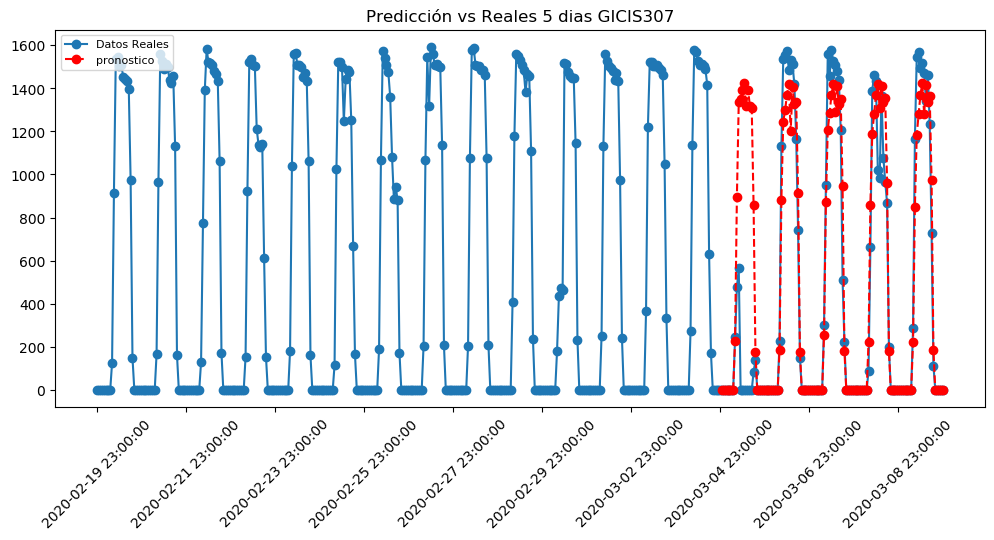

0    0.150406
dtype: float64


In [26]:
    arange_dates = []
    arange_no = []
    arange = datos[columna][-1-19*24:].index
    for i in range(0,len(arange),48):
        arange_dates.append(arange[i])
        arange_no.append(i)

    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(datos[columna][-1-19*24:], 'o-', label = 'Datos Reales')
    plt.plot(pronostico, 'o--', label='pronostico',color ='r')
    plt.title('Predicción vs Reales 5 dias '+columna)
    plt.xticks(arange_no,arange_dates,rotation = 45)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    print(mape_promedio)
    #print(fc)
    #print(model)

In [27]:
Forecasts = pd.DataFrame(fcc).dropna().T

In [28]:
Forecasts.index = test.index
Forecasts.columns = test.columns
round(Forecasts,2)

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-03-05,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,224.41,896.83,1336.74,...,1393.79,1318.48,1307.67,856.60,175.22,-0.0,-0.0,-0.0,-0.0,-0.0
2020-03-06,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,199.11,883.40,1245.70,...,1403.89,1326.07,1335.10,915.39,177.45,-0.0,-0.0,-0.0,-0.0,-0.0
2020-03-07,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,285.11,870.98,1206.27,...,1408.67,1328.04,1348.22,944.83,179.68,-0.0,-0.0,-0.0,-0.0,-0.0
2020-03-08,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,226.52,859.47,1189.20,...,1412.80,1334.68,1357.08,961.91,181.92,-0.0,-0.0,-0.0,-0.0,-0.0
2020-03-09,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,249.82,848.82,1181.81,...,1416.87,1335.02,1364.68,973.79,184.15,-0.0,-0.0,-0.0,-0.0,-0.0


In [29]:
test

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,245.0,476.0,564.0,...,0.0,0.0,0.0,83.0,138.0,0.0,0.0,0.0,0.0,0.0
2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,227.0,1130.0,1534.0,...,1512.0,1418.0,1164.0,740.0,150.0,0.0,0.0,0.0,0.0,0.0
2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,952.0,1557.0,...,1479.0,1437.0,1206.0,510.0,220.0,0.0,0.0,0.0,0.0,0.0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89.0,661.0,1389.0,...,1366.0,1078.0,967.0,866.0,197.0,0.0,0.0,0.0,0.0,0.0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,285.0,1166.0,1547.0,...,1339.0,1461.0,1232.0,728.0,113.0,0.0,0.0,0.0,0.0,0.0


In [30]:
new_mapes = np.abs((Forecasts - test) / test)
new_mapes[new_mapes == inf] = 0

In [31]:
new_mapes

,Hora 1,Hora 2,Hora 3,Hora 4,Hora 5,Hora 6,Hora 7,Hora 8,Hora 9,Hora 10,...,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19,Hora 20,Hora 21,Hora 22,Hora 23,Hora 24
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084049,0.884099,1.370105,...,0.000000,0.000000,0.000000,9.320454,0.269686,0.0,0.0,0.0,0.0,0.0
2020-03-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122868,0.218226,0.187943,...,0.071501,0.064829,0.146993,0.237019,0.182999,0.0,0.0,0.0,0.0,0.0
2020-03-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.049637,0.085110,0.225258,...,0.047556,0.075826,0.117923,0.852601,0.183260,0.0,0.0,0.0,0.0,0.0
2020-03-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.545183,0.300258,0.143842,...,0.034264,0.238106,0.403392,0.110747,0.076569,0.0,0.0,0.0,0.0,0.0
2020-03-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123443,0.272023,0.236062,...,0.058155,0.086230,0.107697,0.337626,0.629637,0.0,0.0,0.0,0.0,0.0


In [32]:
new_mapes[[ 'Hora 8', 'Hora 9', 'Hora 10',
                           'Hora 11', 'Hora 12','Hora 13', 'Hora 14', 'Hora 15',
                          'Hora 16', 'Hora 17', 'Hora 18', 'Hora 19']]

,Hora 8,Hora 9,Hora 10,Hora 11,Hora 12,Hora 13,Hora 14,Hora 15,Hora 16,Hora 17,Hora 18,Hora 19
2020-03-05,0.084049,0.884099,1.370105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.320454,0.269686
2020-03-06,0.122868,0.218226,0.187943,0.164376,0.129200,0.046192,0.108269,0.071501,0.064829,0.146993,0.237019,0.182999
2020-03-07,0.049637,0.085110,0.225258,0.117369,0.130305,0.069217,0.092829,0.047556,0.075826,0.117923,0.852601,0.183260
2020-03-08,1.545183,0.300258,0.143842,0.123897,0.044851,0.391850,0.390252,0.034264,0.238106,0.403392,0.110747,0.076569
2020-03-09,0.123443,0.272023,0.236062,0.184178,0.083185,0.062129,0.066647,0.058155,0.086230,0.107697,0.337626,0.629637


In [33]:
np.mean(new_mapes)

Hora 1     0.000000
Hora 2     0.000000
Hora 3     0.000000
Hora 4     0.000000
Hora 5     0.000000
Hora 6     0.000000
Hora 7     0.000000
Hora 8     0.385036
Hora 9     0.351943
Hora 10    0.432642
Hora 11    0.117964
Hora 12    0.077508
Hora 13    0.113877
Hora 14    0.131600
Hora 15    0.042295
Hora 16    0.092998
Hora 17    0.155201
Hora 18    2.171689
Hora 19    0.268430
Hora 20    0.000000
Hora 21    0.000000
Hora 22    0.000000
Hora 23    0.000000
Hora 24    0.000000
dtype: float64

In [34]:
np.mean(np.mean(new_mapes[['Hora 8', 'Hora 9', 'Hora 10',
                           'Hora 11', 'Hora 12','Hora 13', 'Hora 14', 'Hora 15',
                          'Hora 16', 'Hora 17', 'Hora 18', 'Hora 19']]))

0.3617653618921883